# Using GRASS, NumPy, and Landlab for Scientific Modeling

Anna Petrasova  
2025-10-01

# Introduction

This short tutorial shows how to integrate NumPy arrays with GRASS tools
to create a smooth workflow for scientific modeling and analysis in
Python.

Specifically, it demonstrates a complete workflow: generating a terrain
surface in GRASS, importing it into [Landlab](https://landlab.csdms.io/)
(an open-source Python library for running numerical models of
Earth-surface dynamics), running an erosion model, and then returning
the results to GRASS for further hydrologic analysis.

With the [grass.tools
API](https://grass.osgeo.org/grass-devel/manuals/python_intro.html)
(introduced in GRASS v8.5), tools can now accept and return NumPy arrays
directly, rather than working only with GRASS rasters. While native
rasters remain the most efficient option for large-scale processing,
NumPy arrays make it easy to connect GRASS with the broader Python
scientific ecosystem, enabling advanced analysis and seamless use of
familiar libraries.

> **How to run this tutorial?**
>
> This tutorial is prepared to be run in a Jupyter notebook locally or
> using services such as Google Colab. You can [download the notebook
> here](grass_numpy_integration.ipynb).
>
> If you are not sure how to get started with GRASS, checkout the
> tutorials [Get started with GRASS & Python in Jupyter
> Notebooks](../get_started/fast_track_grass_and_python.qmd) and [Get
> started with GRASS in Google
> Colab](../get_started/grass_gis_in_google_colab.qmd).

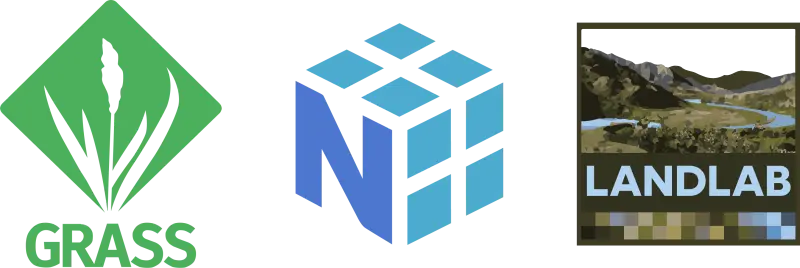

# Generating a fractal surface in GRASS

First we will import GRASS packages:

In [1]:
# import standard Python packages
import os
import sys
import subprocess

# for some environments, this path setup can be skipped
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

# import GRASS Python packages
import grass.script as gs
import grass.jupyter as gj
from grass.tools import Tools

Create a new GRASS project called “landlab”. Since we will be working
with artifical data, we don’t need to provide any coordinate reference
system, resulting in a generic cartesian system.

In [2]:
gs.create_project("landlab")

Initialize a session in this project and create a `Tools` object we will
use for calling GRASS tools:

In [3]:
session = gj.init("landlab")
tools = Tools()

Since we are generating artificial data, we need to specify the
dimensions (number of rows and columns). We also need to let GRASS know
the actual coordinates we want to use; we will do all that by setting
the [computational
region](https://grass.osgeo.org/grass-stable/manuals/g.region.html).
Lower-left (south-west) corner of the data will be at the coordinates
(0, 0), the coordinates of the upper-right (nort-east) corner are number
of rows times cell resolution and number of columns times cell
resolution. We chose a cell resolution of 10 horizontal units, which
would impact certain terrain analyses, such as slope computation, and
certain hydrology processes.

In [4]:
rows = 200
cols = 250
resolution = 10
tools.g_region(s=0, w=0, n=rows * resolution, e=cols * resolution, res=resolution)

## Creating a fractal surface as a NumPy array

We will create a simple fractal surface with
[r.surf.fractal](https://grass.osgeo.org/grass-stable/manuals/r.surf.fractal.html).

The trick is to use the `output` parameter with the value `np.array` to
request a NumPy array instead of a native GRASS raster. This way GRASS
provides the array as the result of the call:

In [5]:
import numpy as np

fractal = tools.r_surf_fractal(output=np.array, seed=6)

> **NumPy arrays in GRASS version \< 8.5**
>
> Directly passing NumPy arrays to GRASS tools and receiving them back
> is a new feature in GRASS v8.5. If you work with older versions of
> GRASS, you can use
> [grass.script.array](https://grass.osgeo.org/grass-stable/manuals/libpython/grass.script.html#script.array.array):
>
> ``` python
> import grass.script as gs
> import grass.script.array as ga
>
> gs.run_command("r.surf.fractal", seed=6, output="fractal")
> fractal = ga.array("fractal")
> ```

Now we can display `fractal` array e.g., using matplotlib library:

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(fractal, cmap='terrain')
plt.colorbar(label='Elevation')
plt.title('Topography from r.surf.fractal')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.show()

<figure>
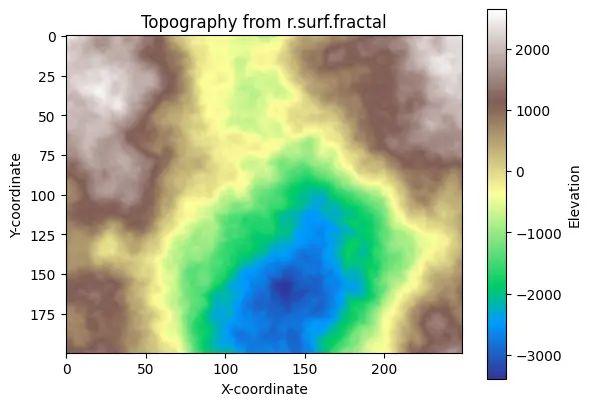
<figcaption aria-hidden="true">Fractal surface generated with
r.surf.fractal displayed using matplotlib</figcaption>
</figure>

We can modify the array:

In [8]:
fractal *= 0.1
fractal = np.abs(fractal)

plt.figure()
plt.imshow(fractal, cmap='terrain')
plt.colorbar(label='Elevation')
plt.title('Modified topography from r.surf.fractal')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.show()

<figure>
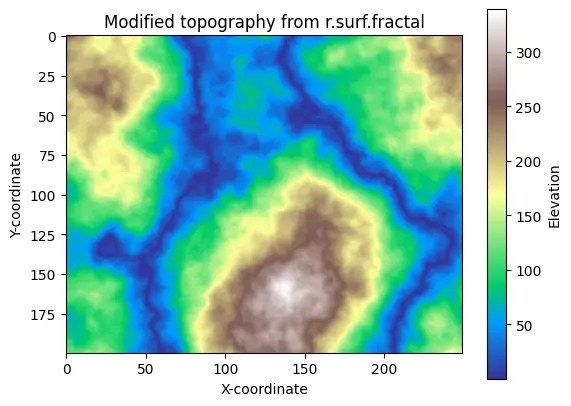
<figcaption aria-hidden="true">Modified fractal surface</figcaption>
</figure>

# From GRASS to Landlab

Now, let’s use Landlab’s modeling capabilities to burn in an initial
drainage network using the Landlab’s [Fastscape
Eroder](https://landlab.readthedocs.io/en/latest/generated/api/landlab.components.stream_power.fastscape_stream_power.html).

Create the `RasterModelGrid` specifying the same dimensions we used for
creating the fractal surface. Add the terrain elevations as a 1D array
(flattened with `ravel`) to the grid’s nodes under the standard field
name “topographic\_\_elevation”.

In [9]:
from landlab import RasterModelGrid

grid = RasterModelGrid((rows, cols), xy_spacing=resolution)
grid.add_field("topographic__elevation", fractal.ravel(), at="node")

Run the erosion of the landscape:

In [10]:
from landlab.components import LinearDiffuser
from landlab.components import FlowAccumulator, FastscapeEroder

fa = FlowAccumulator(grid, flow_director="D8")
fsp = FastscapeEroder(grid, K_sp=0.01, m_sp=0.5, n_sp=1.0)
ld = LinearDiffuser(grid, linear_diffusivity=1)

for i in range(100):
    fa.run_one_step()
    fsp.run_one_step(dt=1.0)
    ld.run_one_step(dt=1.0)

Extract the resulting NumPy array and visualize it:

In [11]:
elevation = grid.at_node['topographic__elevation'].reshape(grid.shape)

plt.figure()
plt.imshow(elevation, cmap='terrain', origin='upper')
plt.colorbar(label='Elevation')
plt.title('Topography after erosion')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.show()

<figure>
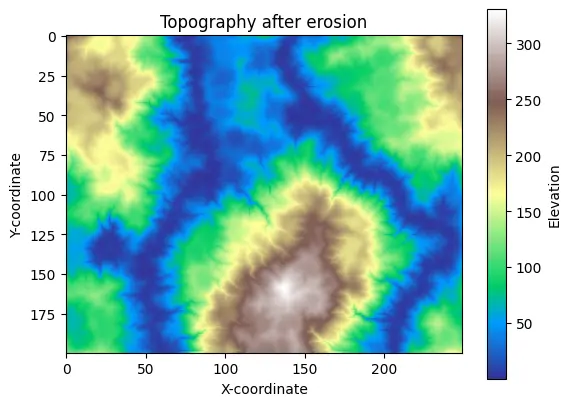
<figcaption aria-hidden="true">Eroded fractal surface with
Landlab</figcaption>
</figure>

# From Landlab to GRASS

Now we will bring the eroded topography back to GRASS for additional
hydrology modeling. We will derive streams using the
[r.watershed](https://grass.osgeo.org/grass-stable/manuals/r.watershed.html)
and
[r.stream.extract](https://grass.osgeo.org/grass-stable/manuals/r.stream.extract.html)
tools.

The `Tools` API allows us to directly plugin the NumPy `elevation` array
into the tool call.

In [12]:
tools.r_watershed(elevation=elevation, accumulation="accumulation")
tools.r_stream_extract(
    elevation=elevation,
    accumulation="accumulation",
    threshold=300,
    stream_vector="streams",
)

And visualize them using `gj.Map` on top of shaded relief:

In [13]:
tools.r_relief(input=elevation, output="relief")

m = gj.Map(width=400)
m.d_rast(map="relief")
m.d_vect(map="streams", type="line", color="blue", width=2)
m.show()

<figure>
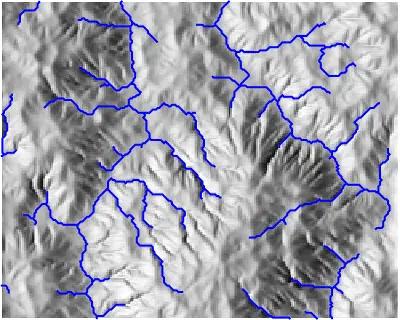
<figcaption aria-hidden="true">Streams derived from eroded topography in
GRASS</figcaption>
</figure>

Now if we want to store the eroded topography as a native GRASS raster,
we can use
[grass.script.array](https://grass.osgeo.org/grass-stable/manuals/libpython/grass.script.html#script.array.array)
to create a GRASS array object with the dimensions given by the current
computational region. Then we copy the NumPy array and write the raster
map as GRASS native raster.

In [14]:
import grass.script.array as ga

# Create a new grasss.script.array object
grass_elevation = ga.array()
# Copy values from elevation array
grass_elevation[...] = elevation
# Write new GRASS raster map 'elevation'
grass_elevation.write("elevation")

> **What about N-dimensional arrays?**
>
> For 3D arrays, you can use
> [grass.script.array3d](https://grass.osgeo.org/grass-stable/manuals/libpython/grass.script.html#script.array.array3d)
> package.
>
> For N-dimensional arrays, check out the new
> [xarray-grass](https://github.com/lrntct/xarray-grass) bridge
> developed by [Laurent Courty](https://github.com/lrntct)

Let’s visualize the new GRASS elevation map with streams by setting its
color scheme to `srtm_percent` and rendering it in 3D using the
[grass.jupyter.Map3D](https://grass.osgeo.org/grass-stable/manuals/libpython/grass.jupyter.html?highlight=map3d#module-grass.jupyter.map3d)
class:

In [15]:
tools.r_colors(map="elevation", color="srtm_percent")
elevation_3dmap = gj.Map3D()
elevation_3dmap.render(
    elevation_map="elevation",
    resolution_fine=1,
    vline="streams",
    vline_width=3,
    vline_color="blue",
    vline_height=3,
    position=[0.50, 0.00],
    height=5600,
    perspective=10,
)
elevation_3dmap.show()

<figure>
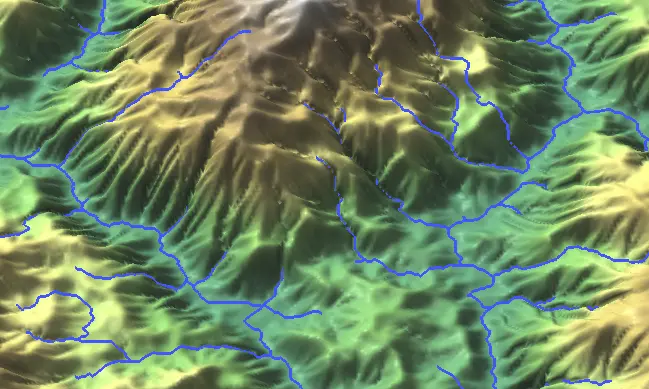
<figcaption aria-hidden="true">Resulting elevation with streams in
3D</figcaption>
</figure>

And now let’s augment it with [Nano Banana AI](https://nanobanana.ai/):

<figure>
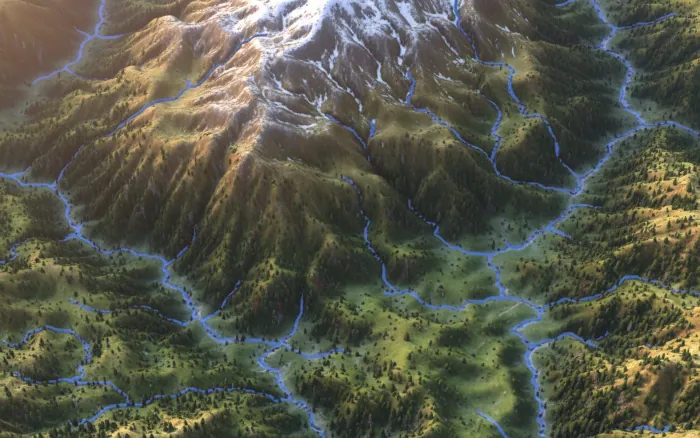
<figcaption aria-hidden="true">AI edited landscape</figcaption>
</figure>

------------------------------------------------------------------------

The development of this tutorial and the `grass.tools` package
(developed by Vaclav Petras) was supported by NSF Award #2322073,
granted to Natrx, Inc.